Датасет для роботи:

https://fred.stlouisfed.org/series/T10Y2Y

На вибір - SARIMA(ARIMA), Darts, Prophet

## INIT BLOCK

### Import and install Requirements

### install

In [1]:
!pip install darts

### import

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from darts import TimeSeries
from darts.models import ExponentialSmoothing, AutoARIMA, ARIMA, XGBModel
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from darts.metrics import mape
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.iolib import SimpleTable
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

### Init

In [3]:
RANDOM_STATE: int = 1729


def mount_google_drive() -> bool | None:
    """
    Function to mount Google Drive.
    :return: True if mounting is successful, None otherwise.
    """
    try:
        from google.colab.drive import mount

        mount(mountpoint="/content/drive")
        return True

    except Exception as error:
        print(f"Error while mounting Google Drive: {error}")
        raise


def get_data_frame(dataset_path: str, *args, sep: str = ",", **kwargs) -> pd.DataFrame | None:
    """
    Function to convert the dataset into a pd.DataFrame.
    :param sep: Separator for csv data, default - ",".
    :param dataset_path: Path or URL of the dataset.
    :return: pd.DataFrame containing the dataset, or None if errors occur.
    """
    try:
        return pd.read_csv(filepath_or_buffer=dataset_path, sep=sep, **kwargs)

    except Exception as error:
        print(f"Error while converting dataset to NumPy array: {error}")
        raise


def get_ds_url():
    return "/content/drive/MyDrive/Hillel/Machine_Learning_Course/HW12/T10Y2Y.csv"


def main(dataset_path: str, *args, **kwargs) -> pd.DataFrame | None:
    """
    Main function to start the app.
    :return: pd.DataFrame containing the dataset, or None if errors occur.
    """
    if mount_google_drive():
        import os

        if os.path.exists(path=dataset_path):
            return get_data_frame(dataset_path=dataset_path, *args, **kwargs)

        else:
            print("Dataset path doesn't exists.")
            raise FileNotFoundError


if __name__ == "__main__":
    source_dataframe: pd.DataFrame | None = main(dataset_path=get_ds_url(), sep=",", index_col="DATE", parse_dates=["DATE"])

    if isinstance(source_dataframe, pd.DataFrame):
        working_dataframe: pd.DataFrame = source_dataframe.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data analysis, clining and optomization

### DataFrame info

In [4]:
working_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12299 entries, 1976-06-01 to 2023-07-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   T10Y2Y  12299 non-null  object
dtypes: object(1)
memory usage: 192.2+ KB


### Index

In [5]:
working_dataframe.index

DatetimeIndex(['1976-06-01', '1976-06-02', '1976-06-03', '1976-06-04',
               '1976-06-07', '1976-06-08', '1976-06-09', '1976-06-10',
               '1976-06-11', '1976-06-14',
               ...
               '2023-07-10', '2023-07-11', '2023-07-12', '2023-07-13',
               '2023-07-14', '2023-07-17', '2023-07-18', '2023-07-19',
               '2023-07-20', '2023-07-21'],
              dtype='datetime64[ns]', name='DATE', length=12299, freq=None)

### DataFrame head

In [6]:
working_dataframe.head()

T10Y2Y
DATE             
1976-06-01   0.68
1976-06-02   0.71
1976-06-03   0.70
1976-06-04   0.77
1976-06-07   0.79

### Обробка відсутніх значеннь

In [7]:
working_dataframe.replace(to_replace=".", value=pd.NA, inplace=True)

print(f"{'Є пропущені значення, потрібна обробка датасету.' if working_dataframe.isna().any().any() else 'Пропущених значень немає.'}", end="\n\n")

Є пропущені значення, потрібна обробка датасету.



Щоб не порушитит частотність даних, відсутні значення видаляти не будемо, а замінемо їх на попередні за індексом.

In [8]:
working_dataframe["T10Y2Y"] = working_dataframe["T10Y2Y"].replace(to_replace=pd.NA, method="ffill")
working_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12299 entries, 1976-06-01 to 2023-07-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   T10Y2Y  12299 non-null  object
dtypes: object(1)
memory usage: 192.2+ KB


### Change column data type

In [9]:
working_dataframe["T10Y2Y"]: pd.Series = working_dataframe["T10Y2Y"].astype(float)
working_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12299 entries, 1976-06-01 to 2023-07-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T10Y2Y  12299 non-null  float64
dtypes: float64(1)
memory usage: 192.2 KB


### Генеруємо статистику

In [10]:
working_dataframe.describe(include="all", percentiles=[.25, .5, .75])

T10Y2Y
count  12299.000000
mean       0.891788
std        0.917065
min       -2.410000
25%        0.210000
50%        0.850000
75%        1.510000
max        2.910000

### Build source plot

<Axes: xlabel='DATE'>

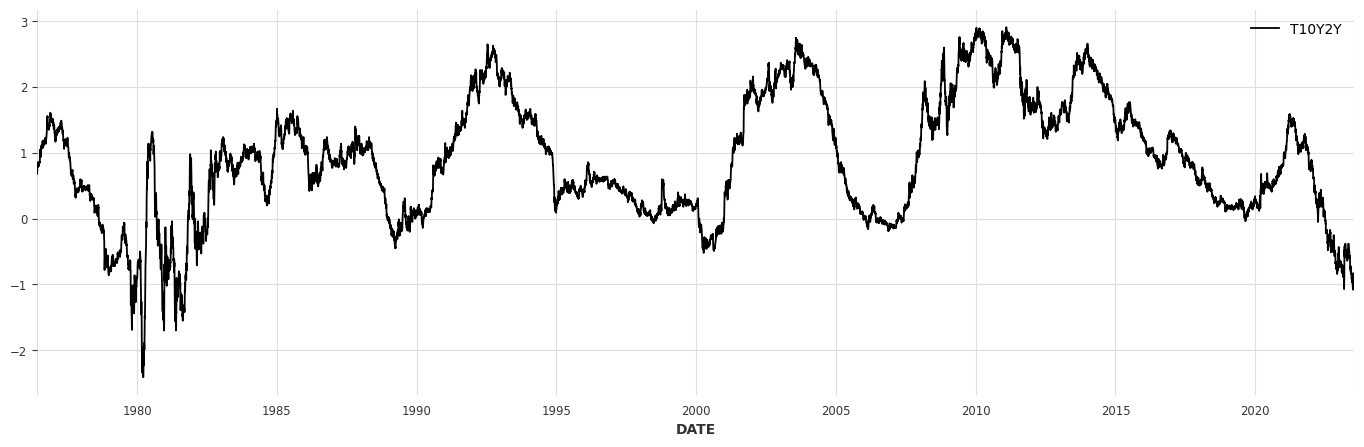

In [11]:
working_dataframe.plot(figsize=(17,5))

бачімо на графіку, що ряд не стаціонарний

# FIT PREDICT

## DARTS

In [12]:
def make_comparative_plot(time_series, predict):
    plt.figure(figsize=(15,6))
    time_series.plot(label="actual", lw=2)
    predict.plot(label="forecast", lw=2)
    plt.legend()
    plt.show()

Convert dataframe to darts TimeSeries

In [13]:
darts_series: TimeSeries = TimeSeries.from_dataframe(df=working_dataframe, value_cols="T10Y2Y")

Split train and validate parts

In [14]:
train, validate = darts_series.split_before(0.615)

Train ExponentialSmoothing model

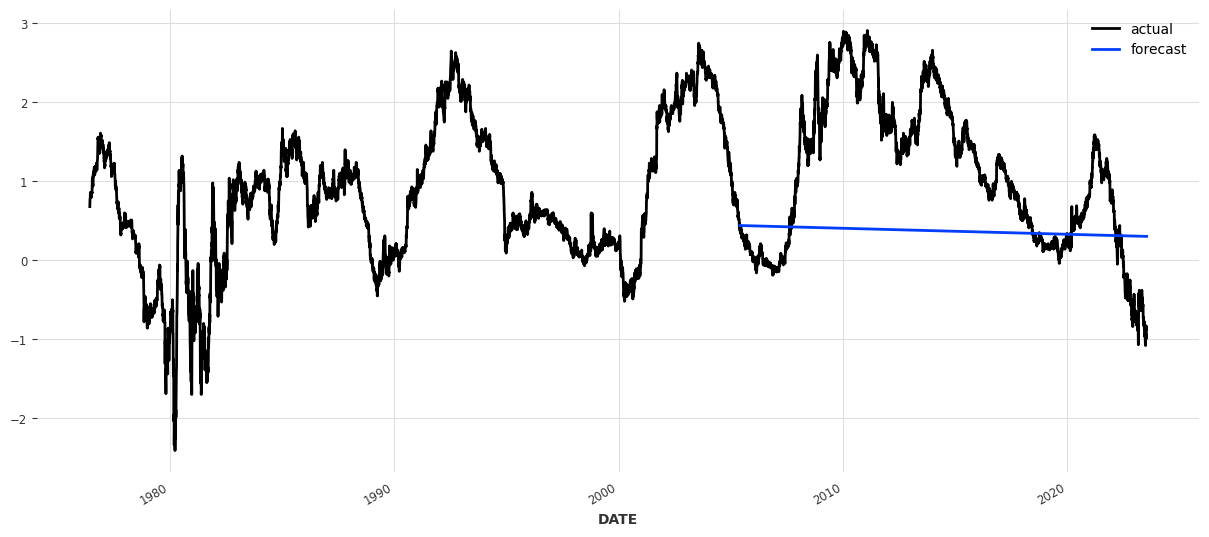

In [15]:
es_model: ExponentialSmoothing = ExponentialSmoothing()
es_model.fit(series=train)
es_predict = es_model.predict(n=len(validate))

make_comparative_plot(time_series=darts_series, predict=es_predict)

AutoARIMA model

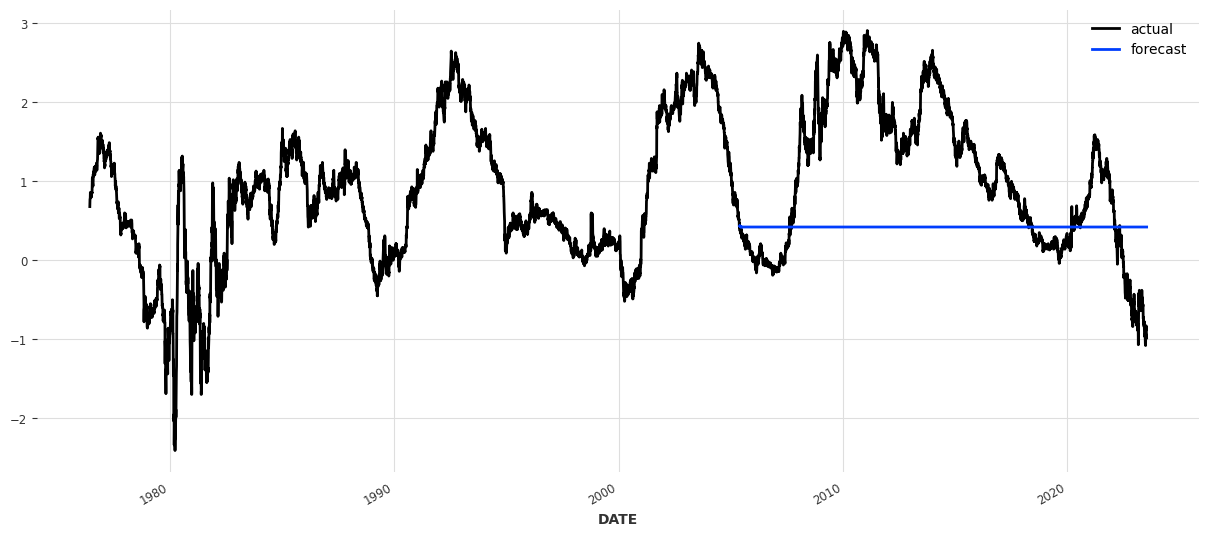

In [16]:
aarima_model: AutoARIMA = AutoARIMA()
aarima_model.fit(train)
aarima_predict = aarima_model.predict(len(validate))

make_comparative_plot(time_series=darts_series, predict=aarima_predict)

ARIMA model

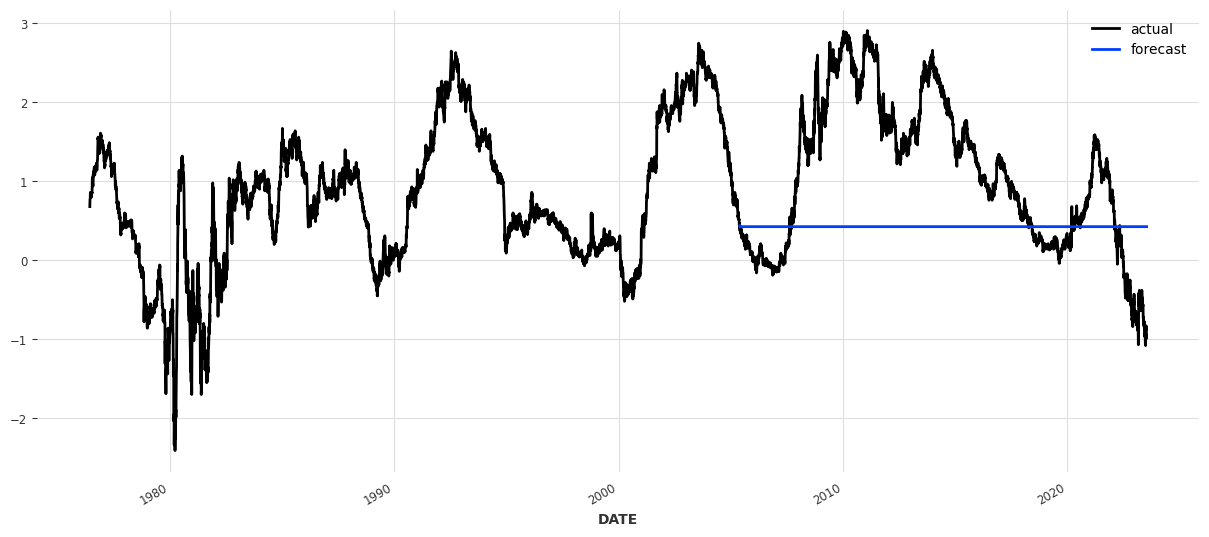

In [17]:
model_arima: ARIMA = ARIMA()
model_arima.fit(series=train)
predict_arima = model_arima.predict(len(validate))

make_comparative_plot(time_series=darts_series, predict=predict_arima)

XGBModel

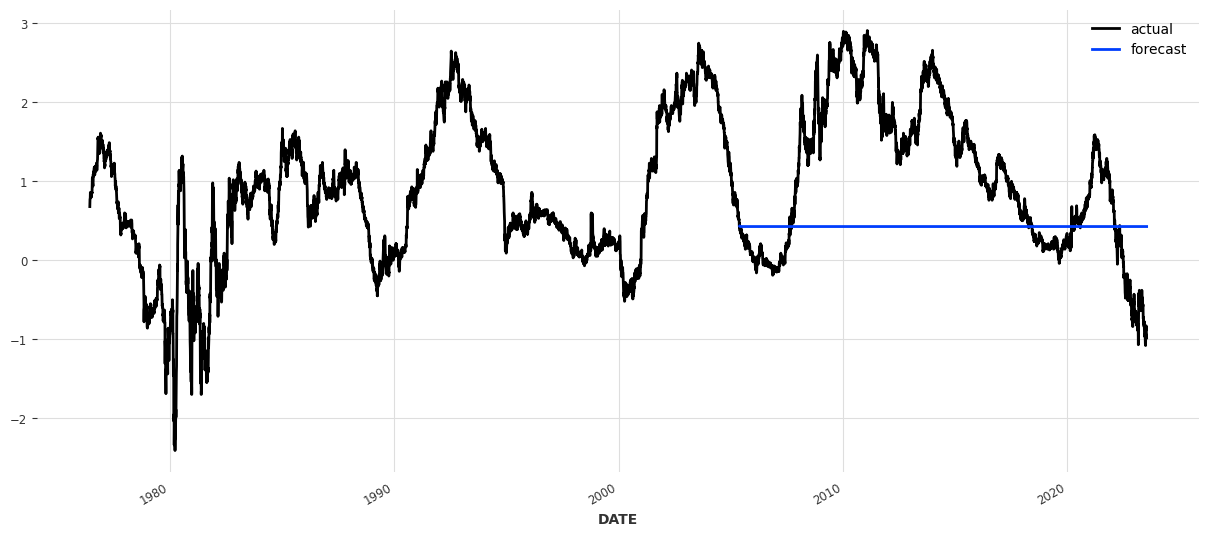

In [18]:
model_xgb: XGBModel = XGBModel(lags=3)
model_xgb.fit(series=train)
predict_xgb = model_xgb.predict(n=len(validate))

make_comparative_plot(time_series=darts_series, predict=predict_xgb)

## FaceBook Prophet

завантажуємо датасет

In [19]:
prophet_df: pd.DataFrame = pd.read_csv(filepath_or_buffer=get_ds_url())

замінюємо хедери на відповідні, щоб prophet працював

In [20]:
prophet_df.rename(columns={"DATE":"ds", "T10Y2Y":"y"}, inplace=True)

обробляємо відсутні значення

In [21]:
prophet_df["y"] = prophet_df["y"].replace(to_replace=".", method="ffill")

навчаємо модель Prophet та робимо форкаст

In [22]:
prophet_model: Prophet = Prophet()
prophet_model.fit(df=prophet_df)

future = prophet_model.make_future_dataframe(periods=300)

forecast = prophet_model.predict(df=future)
forecast.tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkvs_dz_p/wqiwc1v2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkvs_dz_p/bm7iqagb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49032', 'data', 'file=/tmp/tmpkvs_dz_p/wqiwc1v2.json', 'init=/tmp/tmpkvs_dz_p/bm7iqagb.json', 'output', 'file=/tmp/tmpkvs_dz_p/prophet_modelvn4uiomc/prophet_model-20230727185447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
12594 2024-05-12 -0.532768   -1.342776   -0.337922    -0.576302    -0.430754   
12595 2024-05-13 -0.533325   -0.907527    0.225417    -0.577855    -0.430885   
12596 2024-05-14 -0.533883   -0.888855    0.196140    -0.579368    -0.430721   
12597 2024-05-15 -0.534440   -0.868286    0.217159    -0.581594    -0.429359   
12598 2024-05-16 -0.534997   -0.930314    0.206153    -0.582692    -0.428593   

       additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
12594       -0.348791             -0.348791             -0.348791 -0.379629   
12595        0.181968              0.181968              0.181968  0.151622   
12596        0.180932              0.180932              0.180932  0.151119   
12597        0.181641              0.181641              0.181641  0.152406   
12598        0.180903              0.180903              0.180903  0.152304   

       weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
12594     -0.379629     -0.379629  0.030838      0.030838      0.030838   
12595      0.151622      0.151622  0.030346      0.030346      0.030346   
12596      0.151119      0.151119  0.029814      0.029814      0.029814   
12597      0.152406      0.152406  0.029234      0.029234      0.029234   
12598      0.152304      0.152304  0.028599      0.028599      0.028599   

       multiplicative_terms  multiplicative_terms_lower  \
12594                   0.0                         0.0   
12595                   0.0                         0.0   
12596                   0.0                         0.0   
12597                   0.0                         0.0   
12598                   0.0                         0.0   

       multiplicative_terms_upper      yhat  
12594                         0.0 -0.881559  
12595                         0.0 -0.351358  
12596                         0.0 -0.352950  
12597                         0.0 -0.352799  
12598                         0.0 -0.354095

### Будуємо статичні графіки:

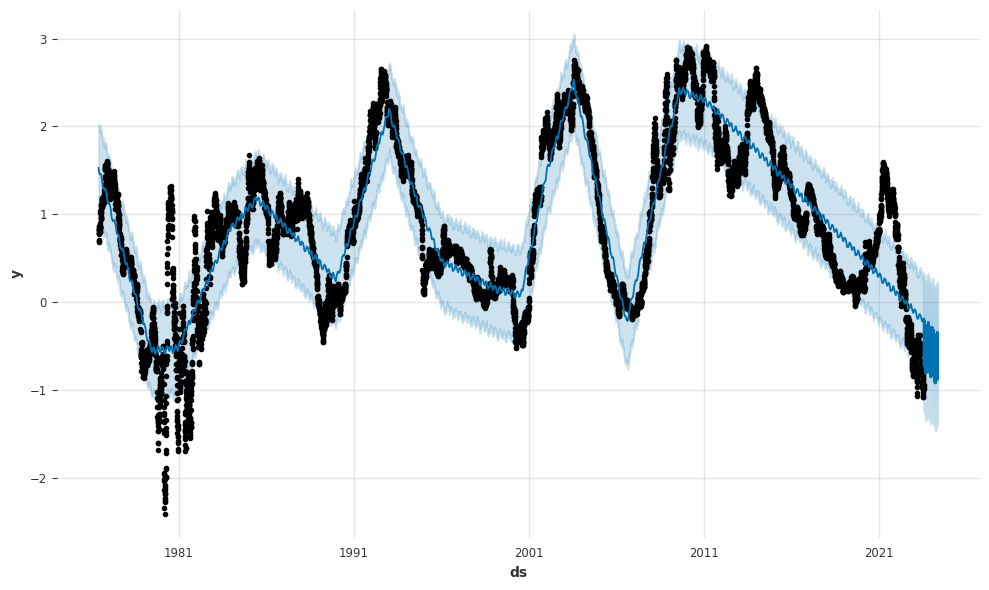

In [23]:
prophet_plot = prophet_model.plot(forecast)

Тут можна побачити побудований сезонний прогноз на заданий відрізо часу (в даному випадку 300 днів)

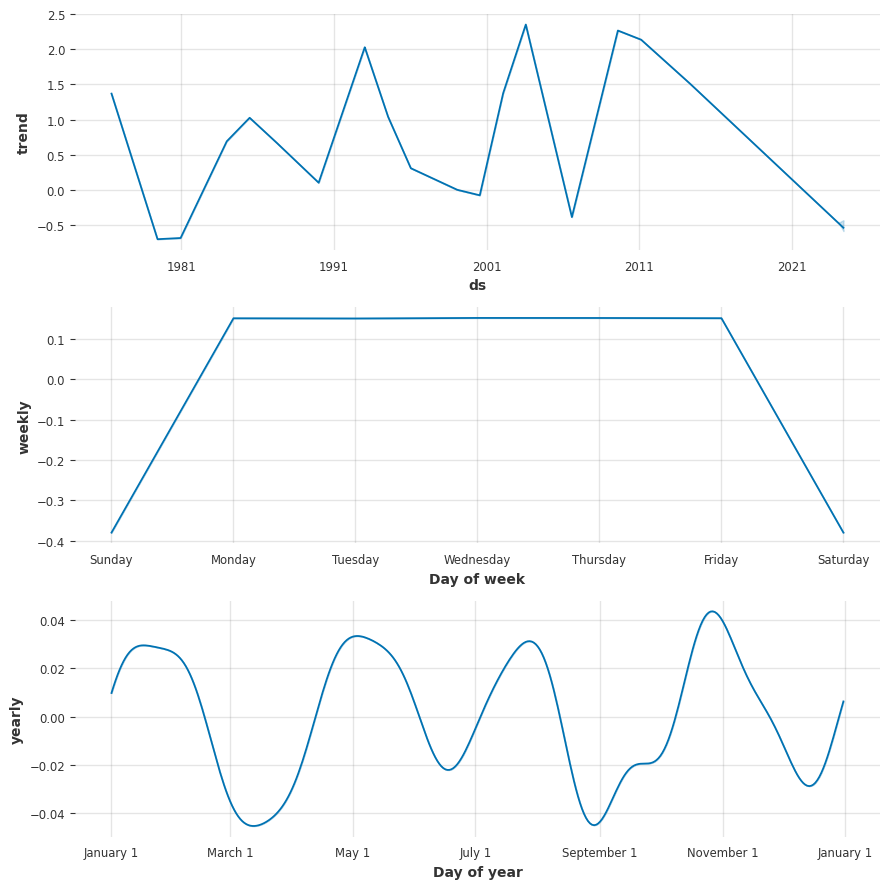

In [24]:
components = prophet_model.plot_components(forecast)

На цьому графіку зображені тенденція, щотижнева сезонність, та щорічна сезонність

### Будуємо інтерактивні графіки

**Ті ж самі графіки але можна збільшити відрізок часу (або просто виділити), щоб детальніше його подивитись, та дослідити.**

In [25]:
plot_plotly(prophet_model, forecast)

In [26]:
plot_components_plotly(prophet_model, forecast)

/usr/local/lib/python3.10/dist-packages/plotly/io/_json.py:534: UserWarning:

Discarding nonzero nanoseconds in conversion.



## Statsmodels ARIMA

In [27]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [28]:
def test_normal_distribution(dataframe):
    print(f"Коефіцієнт варації: {(dataframe.std() / dataframe.mean())}", end="\n\n")

    jb_test = sm.stats.stattools.jarque_bera(dataframe)
    print("Jarque-Bera Test:")
    print(f"JB statistic: {jb_test[0][0]}")
    print(f"JBpv:         {jb_test[1][0]}")
    print(f"skew:         {jb_test[2][0]}")
    print(f"kurtosis:     {jb_test[3][0]}", end="\n\n")

    shapiro_test = stats.shapiro(dataframe)
    print("Shapiro-Wilk Test:")
    print(f"Statistic: {shapiro_test.statistic}")
    print(f"p-value:   {shapiro_test.pvalue}", end="\n\n")

    dagostino_test = stats.normaltest(dataframe)
    print("D'Agostino and Pearson Test:")
    print(f"Statistic: {dagostino_test.statistic[0]}")
    print(f"p-value:   {dagostino_test.pvalue[0]}", end="\n\n")

    plt.figure(figsize=(8, 5))
    sns.histplot(dataframe, kde=True)
    plt.title("Histogram")
    plt.show()

In [29]:
def visualize_decompose(data):
    rcParams["figure.figsize"] = 15, 9
    decompose = seasonal_decompose(data)
    decompose.plot()
    plt.show()

Перевіряємо нормальність розподілу:


In [30]:
# test_normal_distribution(dataframe=working_dataframe)

Як можна побачити з тестів та графіку, розподіл не є нормальним. Спробоємо привести його д нормально.

In [31]:
# smoothed_time_series = working_dataframe.resample("2W").mean()
# smoothed_time_series = working_dataframe.diff(periods=1).dropna()  # диференциація

# test_normal_distribution(dataframe=smoothed_time_series)

Згладили ряд до 4 тижнів, і як можно побачити на графіку і тестах, можна зробити висновок, що розподіл даних статистично не значуще відрізняється від нормального розподілу, тобто дані можуть бути приблизно нормально розподілені.

Перевіримо ряд на стаціонарність:

In [32]:
adf_test(working_dataframe)

Results of Dickey-Fuller Test:
Test Statistic                    -2.823425
p-value                            0.055005
#Lags Used                        35.000000
Number of Observations Used    12263.000000
Critical Value (1%)               -3.430883
Critical Value (5%)               -2.861776
Critical Value (10%)              -2.566895
dtype: float64


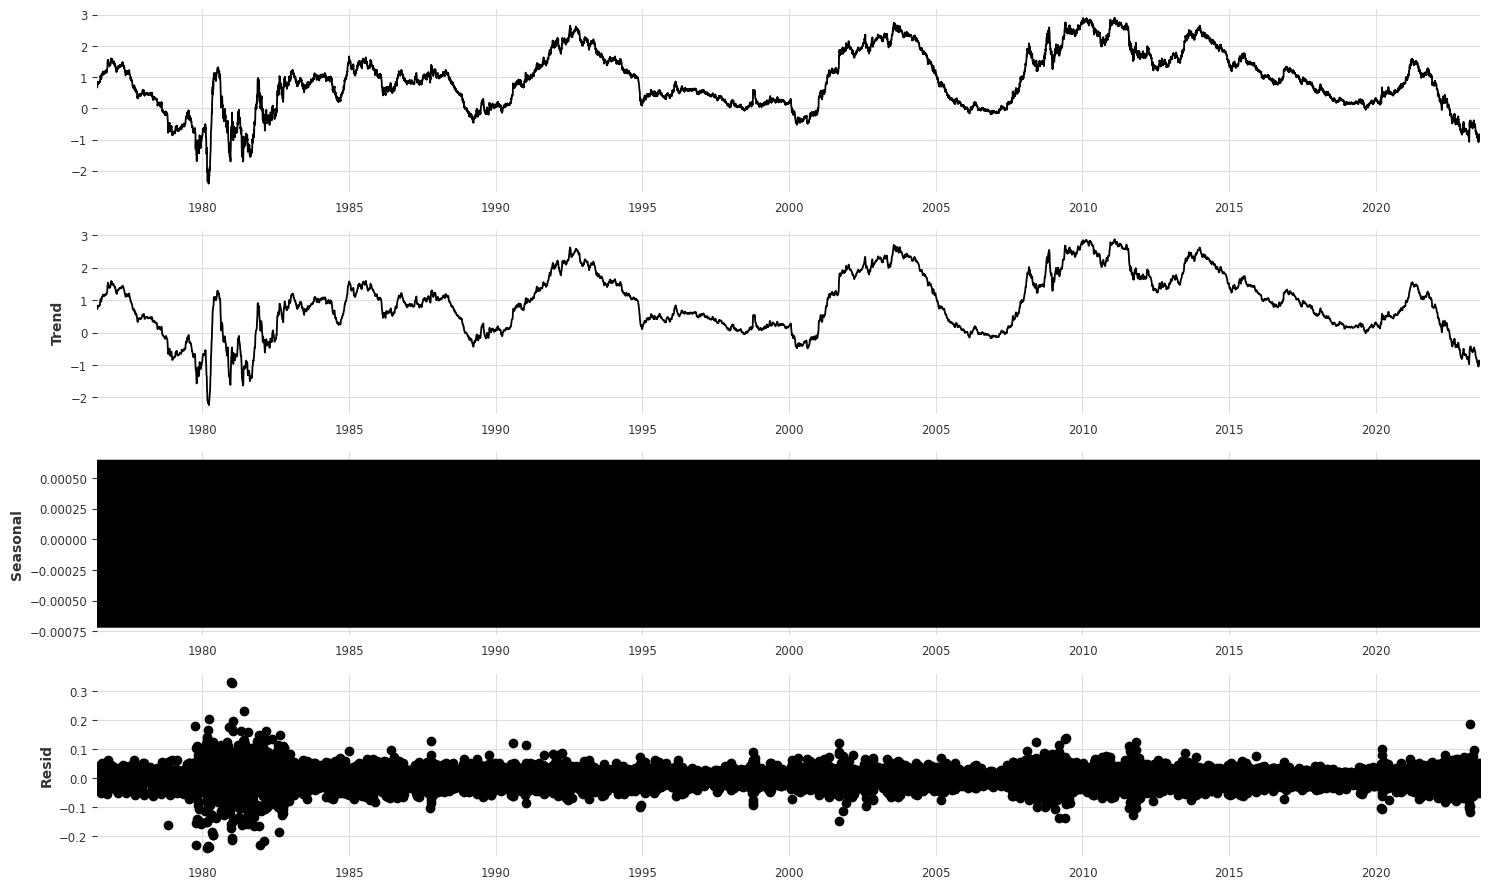

In [33]:
visualize_decompose(working_dataframe)

Судячи з тесту Дікі-Фуллєра та графіків, Ряд не є стаціонарним, потрібна диференціація.

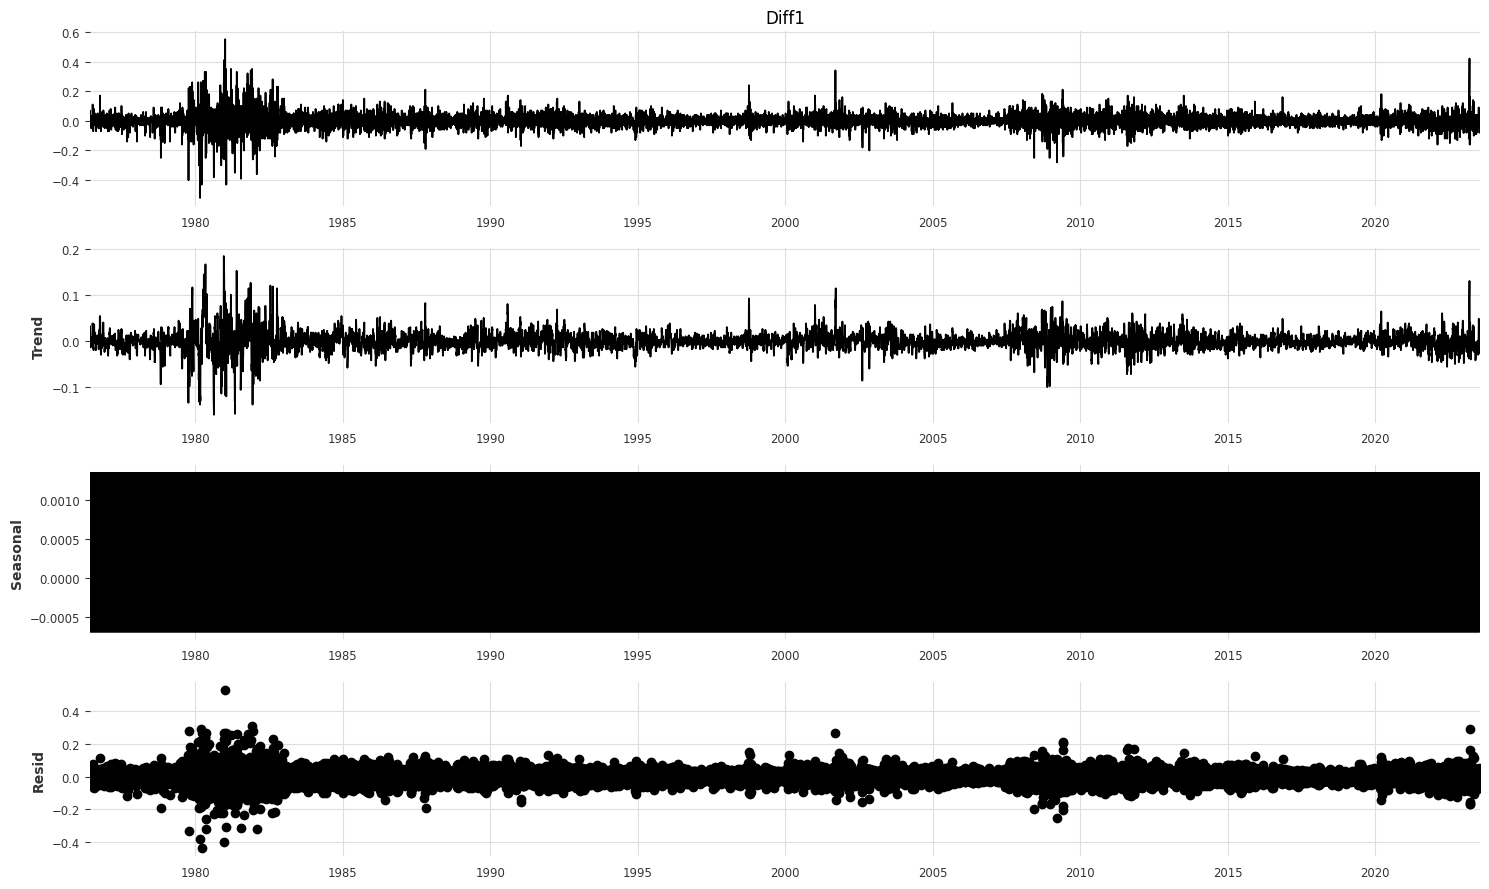

In [34]:
working_dataframe["Diff1"]: pd.Series = working_dataframe["T10Y2Y"].diff()
df_diff1: pd.Series = working_dataframe["Diff1"].dropna()

visualize_decompose(df_diff1)

In [35]:
adf_test(df_diff1)

Results of Dickey-Fuller Test:
Test Statistic                   -18.900003
p-value                            0.000000
#Lags Used                        34.000000
Number of Observations Used    12263.000000
Critical Value (1%)               -3.430883
Critical Value (5%)               -2.861776
Critical Value (10%)              -2.566895
dtype: float64


У даному випадку значення тестової статистики  складає -18.9, а p-value дорівнює 0. Це говорить про те, що p-value менше будь-якого обраного рівня значимості (зазвичай 0.05), що означає, що нульова гіпотеза відхиляється, і ряд є стаціонарним.

Також, значення тестової статистики (-18.9) менше критичних значень (-3.43, -2.86 і -2.57) при рівні значущості 1%, 5% і 10% відповідно, що також підтверджує стаціонарність ряду.

Отже, за результатами тесту Дікі-Фуллера та графіками можна зробити висновок, що ряд є стаціонарним.

Отже для побудови моделі ARIMA, параметр d=1


ACF/PACF

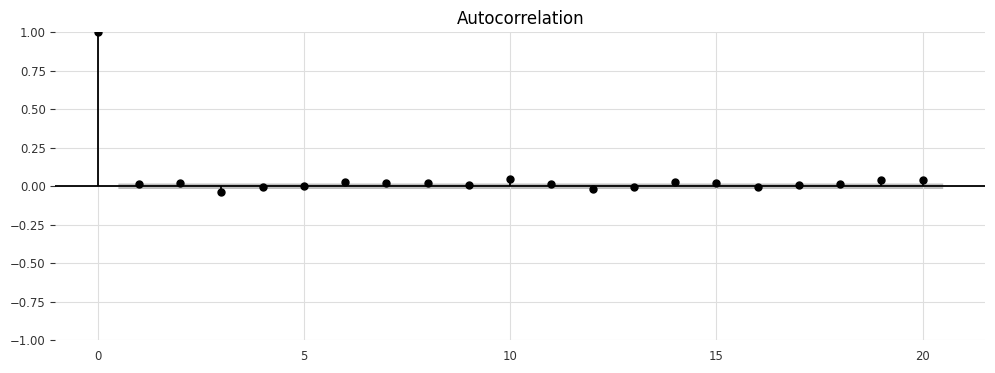

In [43]:
plt.figure(figsize=(12, 4))
plot_acf(df_diff1, lags=20, ax=plt.gca())
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



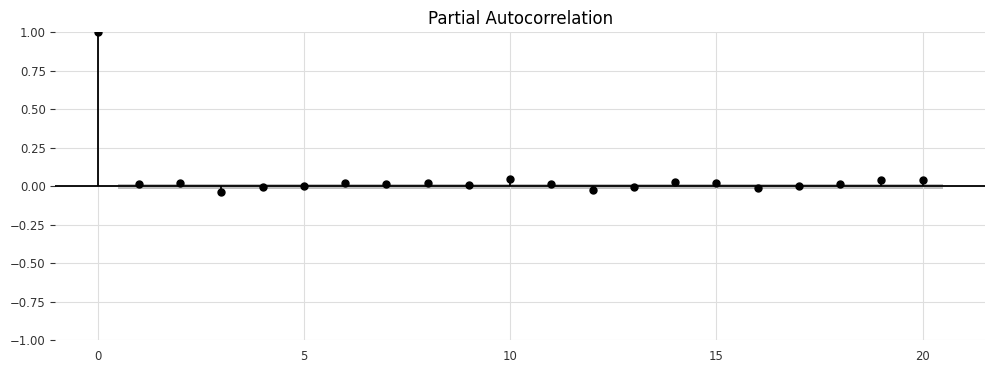

In [44]:
plt.figure(figsize=(12, 4))
plot_pacf(df_diff1, lags=20, ax=plt.gca())
plt.show()

Для побудови моделі ARIMA, будемо брати параметри p=3, q=3.

Будуємо модель ARIMA:

In [37]:
model_arima_manual = sm.tsa.ARIMA(endog=working_dataframe["T10Y2Y"], order=(3, 1, 3))
model_arima_manual_fit = model_arima_manual.fit()
print(model_arima_manual_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



                               SARIMAX Results                                
Dep. Variable:                 T10Y2Y   No. Observations:                12299
Model:                 ARIMA(3, 1, 3)   Log Likelihood               20541.280
Date:                Thu, 27 Jul 2023   AIC                         -41068.560
Time:                        18:55:34   BIC                         -41016.640
Sample:                    06-01-1976   HQIC                        -41051.165
                         - 07-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1493      0.107      1.399      0.162      -0.060       0.358
ar.L2          0.0556      0.099      0.561      0.575      -0.138       0.250
ar.L3         -0.3191      0.101     -3.150      0.0

Будуємо форкаст

<ipython-input-38-b42603e48663>:6: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



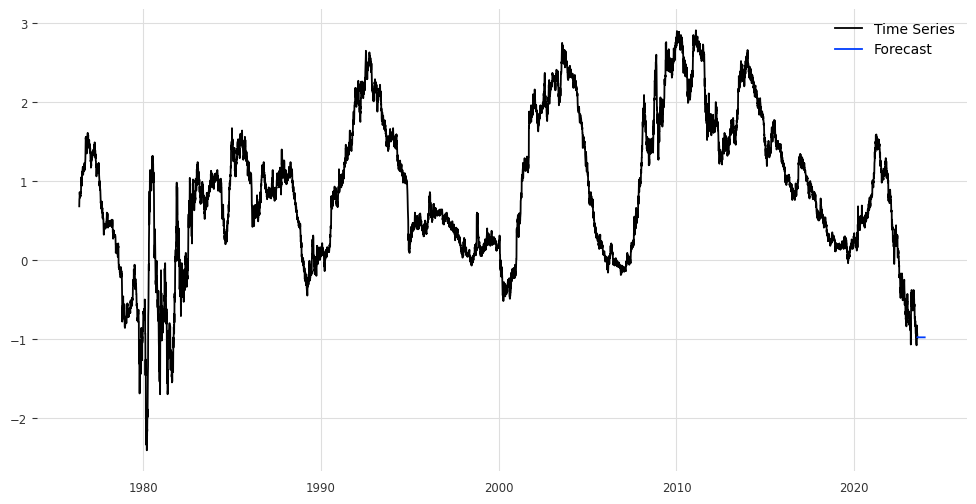

In [38]:
forecast_steps = 150
forecast = model_arima_manual_fit.forecast(steps=forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(working_dataframe.index, working_dataframe["T10Y2Y"], label="Time Series")
plt.plot(pd.date_range(start=working_dataframe.index[-1], periods=forecast_steps+1, closed="right"), forecast, label="Forecast")
plt.legend()
plt.show()

Метрики

In [39]:
train_size: int = int(0.9 * len(working_dataframe))
train_data, test_data = working_dataframe.iloc[:train_size], working_dataframe.iloc[train_size:]

metric_arima = sm.tsa.ARIMA(endog=train_data["T10Y2Y"], order=(3, 1, 3))
metric_arima_fit = metric_arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



In [40]:
forecast_metric_arima = metric_arima_fit.forecast(steps=len(test_data))
mse = mean_squared_error(test_data["T10Y2Y"], forecast_metric_arima)

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.3831853881987801


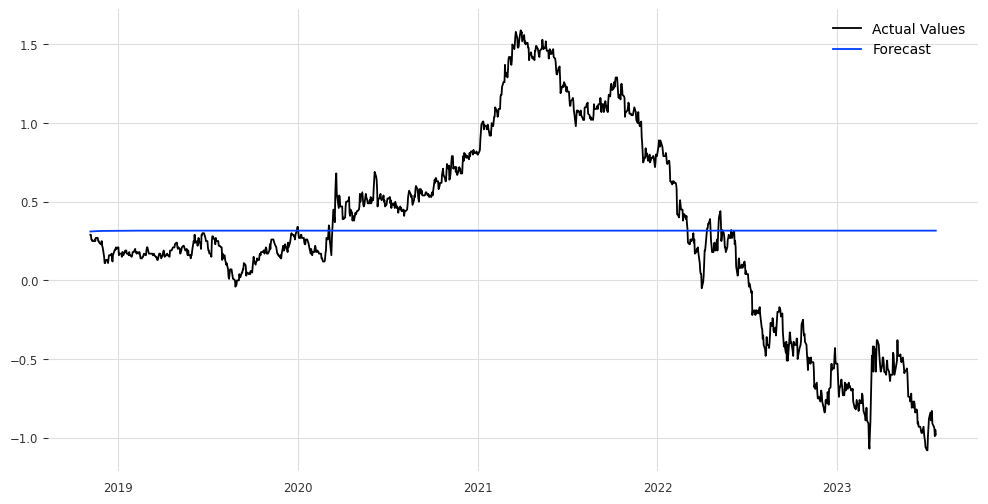

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data["T10Y2Y"], label="Actual Values")
plt.plot(test_data.index, forecast_metric_arima, label="Forecast")
plt.legend()
plt.show()

<Axes: xlabel='DATE'>

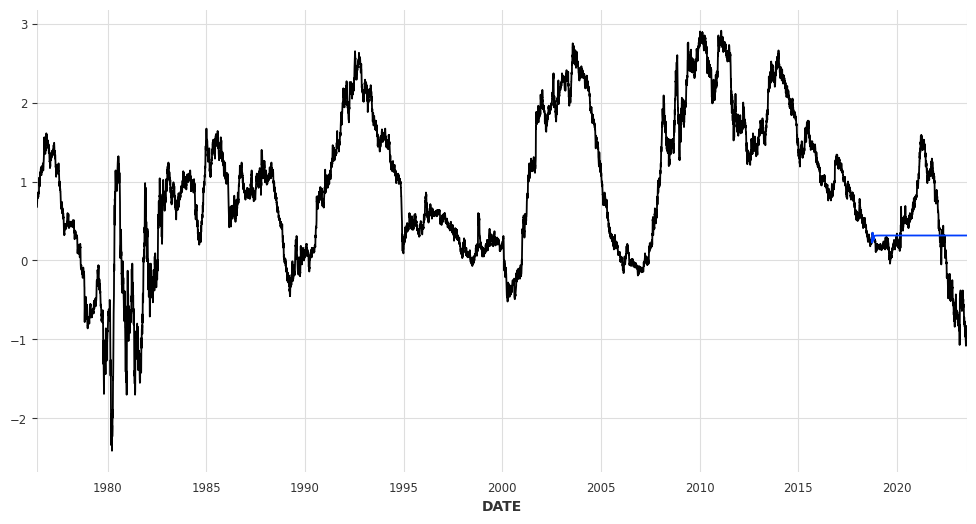

In [42]:
arima_predict = metric_arima_fit.predict("2018-09-25", "2023-07-21")

working_dataframe["T10Y2Y"].plot(figsize=(12,6))
arima_predict.plot()

## Statsmodels SARIMA

# Висновок

1. Побудував декілька моделей через Darts. ExponentialSmoothing, AutoARIMA, ARIMA, XGBModel.
Всі окрім ExponentialSmoothing показали однаковий результат: горизонтальну лінію.
ExponentialSmoothing показує горизонтальну, трохи нахилену вправо лінію.
2. Побудував модель FaceBook Prophet, яка на мій погляд показує значно цікавіший результат + додає сезонність.
3. Боюудував за допомогою бібліотеки Statsmodels модель ARIMA, яка показує такі ж самі результати, як Darts (AutoARIMA, ARIMA, XGBModel).


